In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from scipy.stats import norm
import warnings 
warnings.filterwarnings("ignore")

- scipy : 수치해석 기능을 제공하는 python package
- scipy.stats : 확률분포 분석을 위한 다양한 기능 제공하는 sub package
- norm : 정규 분포

#### 1.데이터 로드

In [2]:
train = pd.read_csv('Data2/train.csv', index_col='Id')
test = pd.read_csv('Data2/test.csv', index_col='Id')
submission = pd.read_csv('Data2/sample_submission.csv', index_col='Id')
data = train #변수가 너무많아서 새로운 변수에 저장
print(train.shape, test.shape,  submission.shape)

(1751, 80) (1168, 79) (1168, 1)


#### 2.데이터 분석하기

1) 타겟 변수 확인
- SalePrice의 분포도를 확인해보자

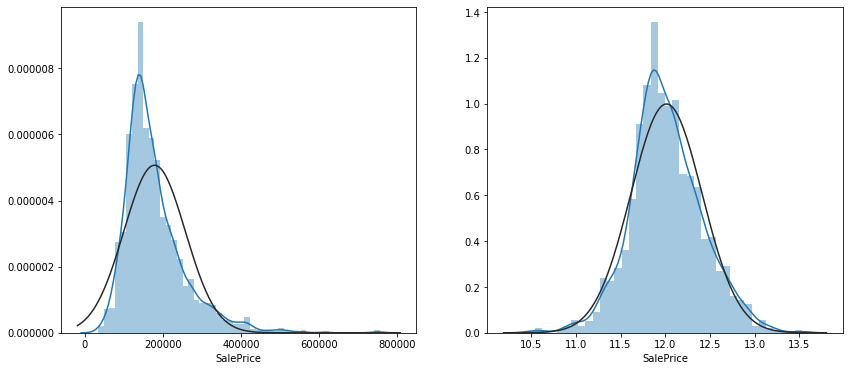

In [3]:
#figure과 axes 객체가 들어있는 tuple을 반환하는 함수 plt.subplots()
#한 화면에 여러 그래프를 나눠 그려주는 기능 있음
figure, (ax1, ax2) = plt.subplots(nrows=1, ncols=2) #2축(ax1,ax2)으로 1행 2열로 그래프 배치
figure.set_size_inches(14,6) #그래프 가로, 세로 길이 (이미 생성되어 있는 figure대상으로 멤버함수 호출하는 방법)
figure.patch.set_facecolor('white') #그래프외부화면 색상
sns.distplot(data['SalePrice'], fit=norm, ax=ax1)
sns.distplot(np.log(data['SalePrice']+1), fit=norm, ax=ax2) #log가 0이면 오류발생하기에 +1(여기선 안해도 오류는X)..np.log1p와같은결과

- 왼쪽 그래프 -> 대부분의 데이터가 한쪽으로(왼쪽) 치우쳐 있음(cf.비대칭정도:Skewness)
- == 오른쪽 꼬리가 긴 Right Skewed == Positive Skewed (power law function)
- --> 즉 오른쪽 부분은 데이터가 적어서 학습이 잘 되지 않을 가능성 있음
- --> Right Skewed 해결방법 중 1.. log변환(log transformation)으로 정규분포(normal distribution)

2) 변수간 상관관계 확인

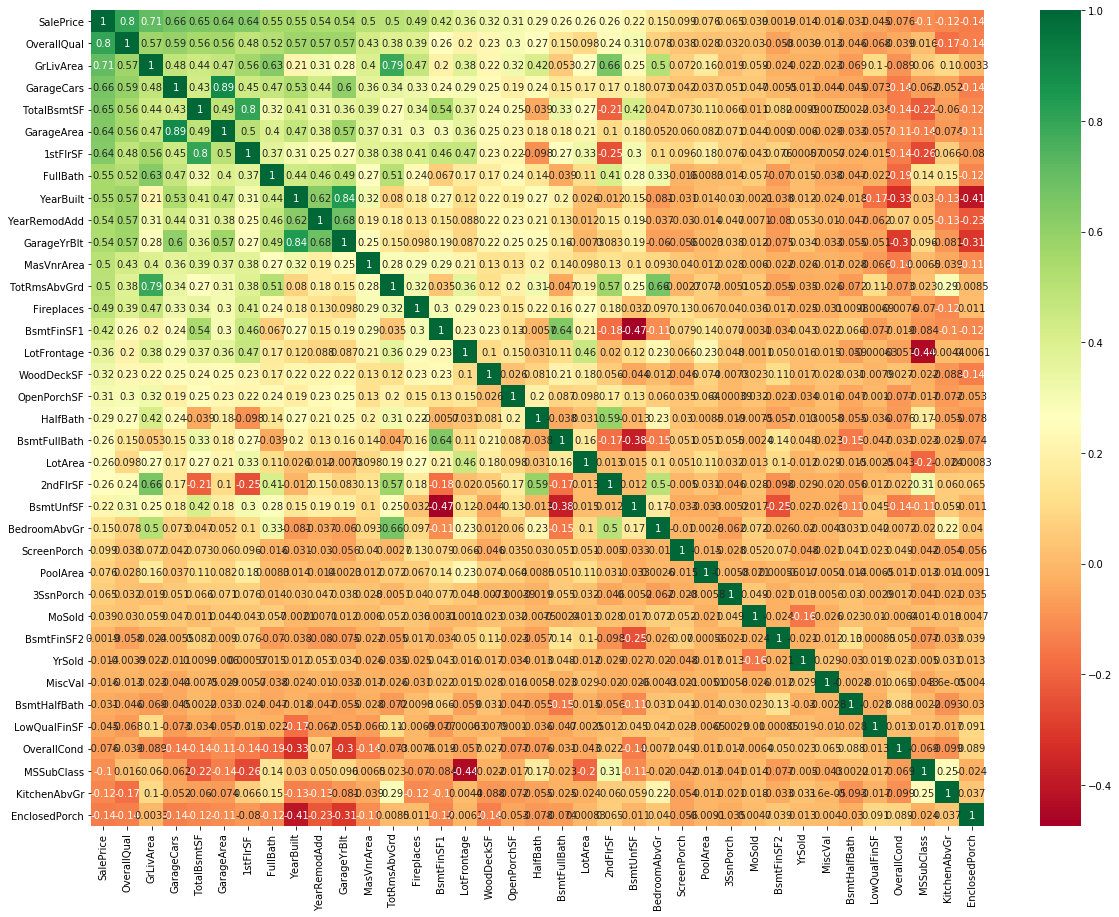

In [4]:
corr = data.corr() #corr()함수로 훈련데이터셋 내 모든 변수들의 상관관계 확인
top_corr = data[corr.nlargest(40,'SalePrice')['SalePrice'].index].corr() #타켓과 상관관계 큰 값의 인덱스를 차례로 40개 저장
    #(상관관계높은순서대로 출력할갯수n, '이 특성을 기준으로!열').index 출력
    #.index전에 ['SalePrice']안써도.. 제대로 나오긴 함

figure, ax1 = plt.subplots(nrows=1, ncols=1) #1행1열로~~
figure.set_size_inches(20,15)

sns.heatmap(top_corr, annot=True, ax=ax1, cmap='RdYlGn') #annot=True이면 셀 안에 각각의 데이터값 출력

- 전반적으로 OverallQual 증가 시 --> 집값도 증가한다!?
- ((OverallQual)전체적 품질: 주택의 전체 자재 및 마감에 대한 평가)

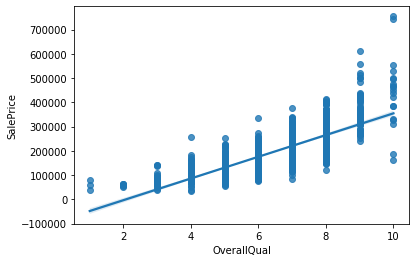

In [5]:
sns.regplot(data['OverallQual'], data['SalePrice'])  #추세선을 넣을 때 사용하는 regplot.. 그리고(x축,y축)

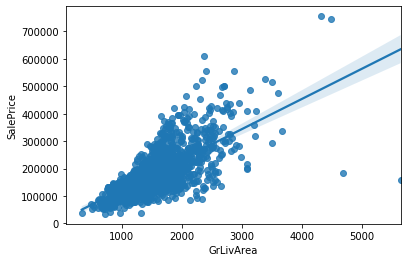

In [6]:
sns.regplot(data['GrLivArea'], data['SalePrice']) #두번째로 큰 상관관계가진 'GrLivArea'(1등급 이상(지상) 거주 지역 평방 피트)

오른쪽 아래 두 개의 이상치로 보이는 데이터들! 삭제하자!

In [7]:
train = train.drop(train [(train['GrLivArea']>4000)&(train['SalePrice']<300000)].index)

In [8]:
y_train = train['SalePrice'] #정답(타켓) 저장

In [9]:
train = train[list(test)] #test에는 saleprice컬럼 없음. SalePrice없게끔 분리 해주는 작업

##### concat 훈련데이터&테스트데이터 ~~> 데이터 합치기
-> 왜? train셋과 test셋에 동일한 특성공학을 적용해 주기 위해서

In [10]:
all_data = pd.concat((train, test), axis=0)
print(all_data.shape)

(2917, 79)


In [11]:
y_train = np.log(y_train+1) #log0의 값이 없기때문에 +1 == log1p 
#만약 SalesPrice의 값 중 하나라도 0이라면 log0은 마이너스 무한대로 커지기에.. 이를 방지하기 위함

3) 전체 데이터에서 결측치 확인

In [12]:
cols = list(all_data) #전체 데이터의 특성이름들을 리스로 만들어 cols에 담아줌 (여기선 79ea)

for col in list(all_data):
    if(all_data[col].isnull().sum())==0: #각 특성의 null개수마다 덧셈. 만약==0(결측치가 없다)이라면
        cols.remove(col) #해당 특성의 이름은 지워라
    else:
        pass  #결측치있는 특성이름만 쌓임
    
print("결측치가 있는 특성의 개수 :",len(cols))
print(cols)

결측치가 있는 특성의 개수 : 34
['MSZoning', 'LotFrontage', 'Alley', 'Utilities', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Electrical', 'BsmtFullBath', 'BsmtHalfBath', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType']


In [13]:
#집에 해당 시설물이 없다? == 있다 없다와 같이 '범주형(카테고리형)' -> 결측치를 'None'이란 "문자열"로 채움
for col in ('PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'GarageType', 'GarageFinish', 
            'GarageQual', 'GarageCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 
            'BsmtFinType2', 'MasVnrType', 'MSSubClass'):
    all_data[col] = all_data[col].fillna('None')

# 면적==0과 같이 수치형변수로 집에 해당 시설 없다? -> 결측치를 0이란 숫자로 채움
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
            'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'MasVnrArea','LotFrontage'):
    all_data[col] = all_data[col].fillna(0)
    
# 해당시설이 없을 수가 없다고 보는 경우?(거래타입이 없을 수가 없음) 
# -> 해당 특성의 최빈값(통계자료 중 최대의 도수 가지는 변량의 수치)으로 채움
for col in ('MSZoning', 'Electrical', 'KitchenQual', 'Exterior1st', 'Exterior2nd', 'SaleType', 
            'Functional', 'Utilities'):
    all_data[col] = all_data[col].fillna(all_data[col].mode()[0])
    
print("결측치 남은 게 있니? :", all_data.isnull().sum().sum() )

결측치 남은 게 있니? : 0


4) 데이터 분석(EDA: Exploratory Data Analysis)

(1) 총 가용면적

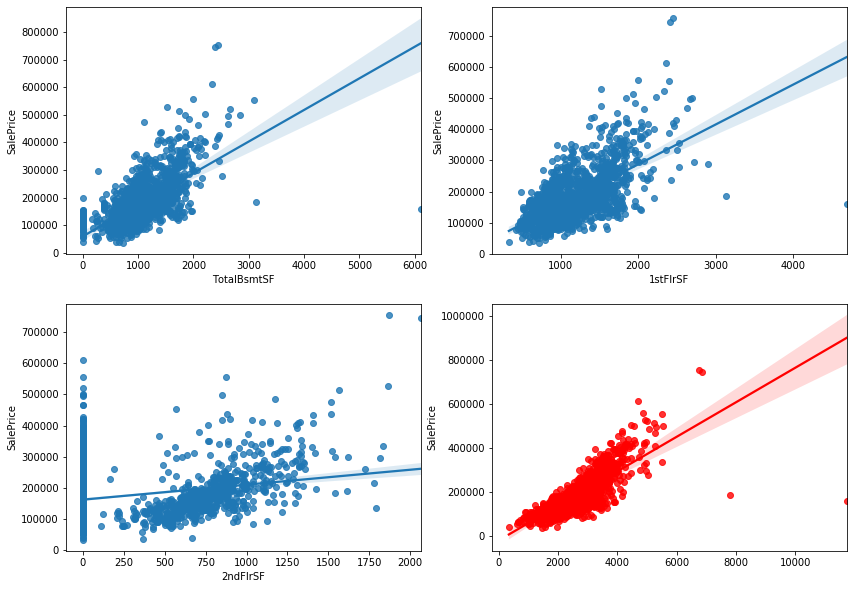

In [14]:
figure, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2)  #2행2열로 그래프 만들어 한 화면에배치
figure.set_size_inches(14,10)

sns.regplot(data['TotalBsmtSF'], data['SalePrice'], ax=ax1) #(1행1열에)  #지하면적
sns.regplot(data['1stFlrSF'], data['SalePrice'], ax=ax2) #1층면적
sns.regplot(data['2ndFlrSF'], data['SalePrice'], ax=ax3) #2층면적
sns.regplot(data['TotalBsmtSF'] + data['1stFlrSF'] + data['2ndFlrSF'], data['SalePrice'], ax=ax4,
            line_kws={'color': 'red'}, scatter_kws={'color': 'red'})

지하면적+1층면적+2층면적이 집 값과의 상관관계가 높아보인다! 

In [15]:
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']
all_data['No2ndFlr'] = (all_data['2ndFlrSF']==0) #2층 없는 집
all_data['NoBsmt']=(all_data['TotalBsmtSF']==0)  #지하실 없는 집

(2) 총 욕실 수 

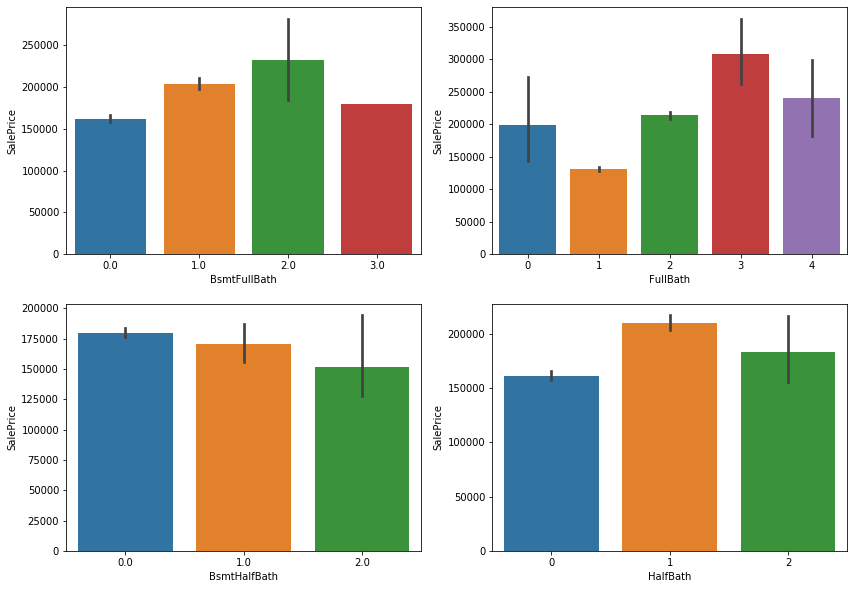

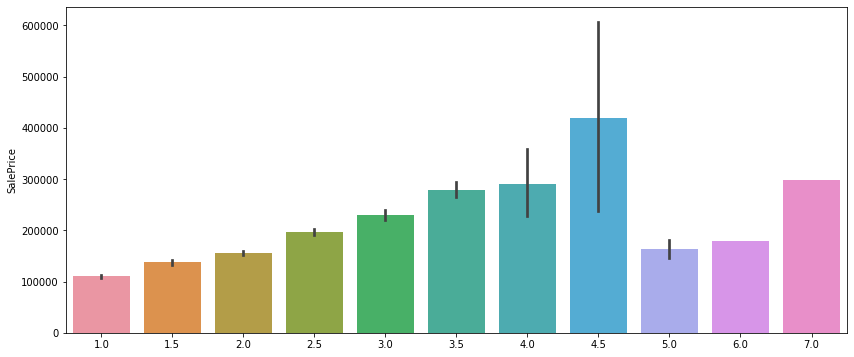

In [16]:
figure, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2)
figure.set_size_inches(14,10)
sns.barplot(data['BsmtFullBath'], data['SalePrice'], ax=ax1)
sns.barplot(data['FullBath'], data['SalePrice'], ax=ax2)  #욕조 및 사워 시설이 포함되어있는 욕실
sns.barplot(data['BsmtHalfBath'], data['SalePrice'], ax=ax3)
sns.barplot(data['HalfBath'], data['SalePrice'], ax=ax4)  # 변기와 세면대 정도 있는 간단한 욕실

figure, (ax5) = plt.subplots(nrows=1, ncols=1)
figure.set_size_inches(14,6)
sns.barplot(data['BsmtFullBath'] + data['FullBath'] + (data['BsmtHalfBath']/2) + (data['HalfBath']/2), 
            data['SalePrice'], ax=ax5)

- 욕실 수 많을 수록? 집이 크겠지?? --> 집값이 비싸진다고 볼 수 있다
- 막대그래프 위의 검은 선: 편차를 의미 (욕실이 6,7개인 집은.. 값이 하나씩밖에 없다고 볼 수 있겠지? == outlier로 판단하고 지울 것)

In [17]:
all_data['TotalBath'] = all_data['BsmtFullBath'] + all_data['FullBath'] + (all_data['BsmtHalfBath']/2) + (all_data['HalfBath']/2)

(3) 건축연도 + 리모델링연도

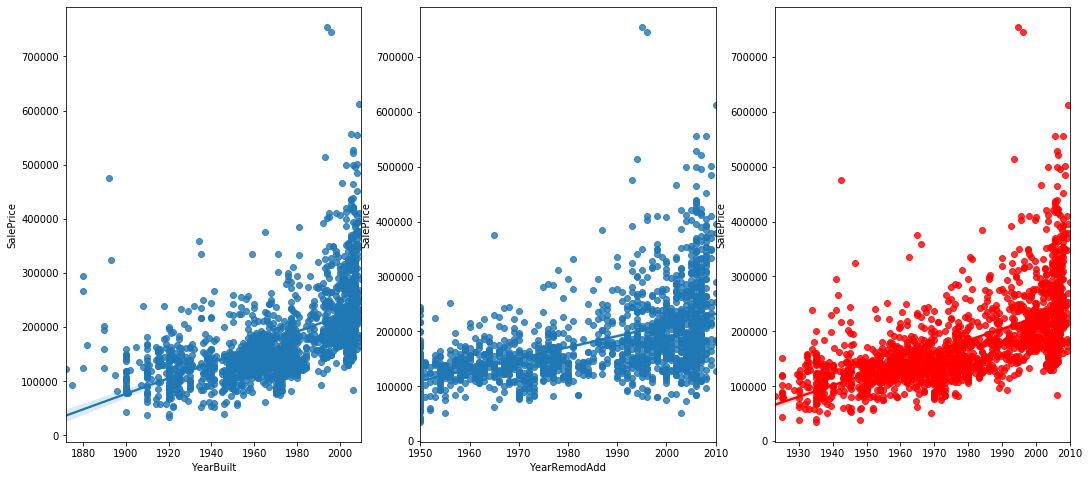

In [18]:
figure, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3)
figure.set_size_inches(18,8)
sns.regplot(data['YearBuilt'], data['SalePrice'], ax=ax1)  #건축연도
sns.regplot(data['YearRemodAdd'], data['SalePrice'], ax=ax2)  #리모델링연도
sns.regplot((data['YearBuilt']+data['YearRemodAdd'])/2, data['SalePrice'], ax=ax3,
           line_kws={'color': 'red'}, scatter_kws={'color': 'red'}) #'/2' for graph scaling

- 건축 이후 리모델링x -> 집값낮을거고
- 건축 오래됐어도, 최근 리모델링? -> 집값 높게 나왔을 것이다
- 신축+리모델링까지 함 -> 집 값 높을 것

In [19]:
all_data['YrBltAndRemod'] = all_data['YearBuilt']+all_data['YearRemodAdd']

5) 자료형 수정하기

In [20]:
all_data['MSSubClass'] #MSSubClass는 분양에 관여하는 주거의 유형을 식별하는 코드로.. 20은 1층 1946 이상 모든스타일 과같이 각각의 숫자에 의미가 담겨있음
#즉 숫자형 데이터지만 범주형변수로서 연산개념 적용에 무리가 있음

Id
1       20
2       20
3       20
4       60
5       20
        ..
2915    20
2916    50
2917    20
2918    60
2919    20
Name: MSSubClass, Length: 2917, dtype: int64

In [21]:
all_data['MSSubClass'] = all_data['MSSubClass'].astype(str) #문자열로 바꿔주자
all_data['MoSold'] = all_data['MoSold'].astype(str) #판매월
all_data['YrSold'] = all_data['YrSold'].astype(str) #판매년도

(6) 지하실(Bsmt) 점수

In [22]:
Basement = ['BsmtCond', 'BsmtExposure', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtFinType1', 'BsmtFinType2', 
            'BsmtQual', 'BsmtUnfSF', 'TotalBsmtSF']
Bsmt = all_data[Basement] #지하실 관련 변수들 묶어서 저장

In [23]:
#Bsmt

In [24]:
#data description 참조
Bsmt = Bsmt.replace(to_replace='Po', value=1) #안좋으면 낮은 숫자
Bsmt = Bsmt.replace(to_replace='Fa', value=2)
Bsmt = Bsmt.replace(to_replace='TA', value=3)
Bsmt = Bsmt.replace(to_replace='Gd', value=4)
Bsmt = Bsmt.replace(to_replace='Ex', value=5)
Bsmt = Bsmt.replace(to_replace='None', value=0) #지하실이 없다? 0

Bsmt = Bsmt.replace(to_replace='No', value=1)
Bsmt = Bsmt.replace(to_replace='Mn', value=2)
Bsmt = Bsmt.replace(to_replace='Av', value=3)
Bsmt = Bsmt.replace(to_replace='Gd', value=4)

Bsmt = Bsmt.replace(to_replace='Unf', value=1)
Bsmt = Bsmt.replace(to_replace='LwQ', value=2)
Bsmt = Bsmt.replace(to_replace='Rec', value=3)
Bsmt = Bsmt.replace(to_replace='BLQ', value=4)
Bsmt = Bsmt.replace(to_replace='ALQ', value=5)
Bsmt = Bsmt.replace(to_replace='GLQ', value=6) #좋으면 높은 숫자

In [25]:
#Bsmt

In [26]:
#지하실의 전반적인 상태를 복합적으로 평가
Bsmt['BsmtScore'] = Bsmt['BsmtQual']  * Bsmt['BsmtCond'] * Bsmt['TotalBsmtSF'] #지하실((높이*전반적인상태)평가*면적)
all_data['BsmtScore'] = Bsmt['BsmtScore'] #all_data에 담아줌

### 타입1마감 평방피트 * 지하마감면적 정격 * 타입2마감 완제품 평방피트 * 지하 마감 구역의 등급
Bsmt['BsmtFin'] = (Bsmt['BsmtFinSF1'] * Bsmt['BsmtFinType1']) + (Bsmt['BsmtFinSF2'] * Bsmt['BsmtFinType2'])
#지하실의 완성도 점수
all_data['BsmtFinScore'] = Bsmt['BsmtFin'] #all_data에 담아줌
#지하실의 미완성도 점수
all_data['BsmtDNF'] = (all_data['BsmtFinScore']==0)

(7) 토지 점수

In [27]:
lot = ['LotFrontage', 'LotArea','LotConfig','LotShape'] #토지관련 데이터들 묶어서
Lot = all_data[lot] #all_data의 lot에담긴 위의 특성들만 추출하여 Lot변수에 저장

Lot['LotScore'] = np.log( (Lot['LotFrontage'] * Lot['LotArea']) +1) #점수만들어 lotScore에 저장

all_data['LotScore'] = Lot['LotScore'] #all_data에 저장

In [28]:
#all_data

(8) 차고 점수

In [29]:
# 차고관련 데이터들 묶어서 list타입 garage에 담고
garage = ['GarageArea','GarageCars','GarageCond','GarageFinish','GarageQual','GarageType','GarageYrBlt']
Garage = all_data[garage] #all_data의 garage에담긴 위의 특성들만 추출하여 Garage 변수에 저장
all_data['NoGarage'] = (all_data['GarageArea']==0) #차고크기가0이라면? == 차고가 없다는 뜻

In [30]:
all_data[garage]

,GarageArea,GarageCars,GarageCond,GarageFinish,GarageQual,GarageType,GarageYrBlt
Id,,,,,,,
1,540.0,2.0,TA,Fin,TA,Attchd,1988.0
2,576.0,2.0,TA,Unf,TA,Detchd,1979.0
3,530.0,2.0,TA,RFn,TA,Attchd,2002.0
4,434.0,1.0,TA,Unf,TA,BuiltIn,1997.0
5,440.0,2.0,TA,RFn,TA,Attchd,1968.0
...,...,...,...,...,...,...,...
2915,0.0,0.0,None,None,None,None,0.0
2916,625.0,1.0,TA,Unf,TA,Detchd,1950.0
2917,308.0,1.0,TA,RFn,TA,Attchd,1959.0


In [31]:
#GarageCond
Garage = Garage.replace(to_replace='Po', value=1)
Garage = Garage.replace(to_replace='Fa', value=2)
Garage = Garage.replace(to_replace='TA', value=3)
Garage = Garage.replace(to_replace='Gd', value=4)
Garage = Garage.replace(to_replace='Ex', value=5)
Garage = Garage.replace(to_replace='None', value=0)

#GarageFinish
Garage = Garage.replace(to_replace='Unf', value=1)
Garage = Garage.replace(to_replace='RFn', value=2)
Garage = Garage.replace(to_replace='Fin', value=3)

#GarageType
Garage = Garage.replace(to_replace='CarPort', value=1)
Garage = Garage.replace(to_replace='Basment', value=4)
Garage = Garage.replace(to_replace='Detchd', value=2)
Garage = Garage.replace(to_replace='2Types', value=3)
Garage = Garage.replace(to_replace='Basement', value=5)
Garage = Garage.replace(to_replace='Attchd', value=6)
Garage = Garage.replace(to_replace='BuiltIn', value=7)

Garage['GarageScore'] = ( (Garage['GarageArea']) * (Garage['GarageCars']) * (Garage['GarageFinish']) 
                        * (Garage['GarageQual']) * (Garage['GarageType']) )
all_data['GarageScore'] = Garage['GarageScore']

(9) 기타 변수

- 비상적으로 하나의 값만 많은 변수들 삭제

In [32]:
all_data['Street'].value_counts()

Pave    2905
Grvl      12
Name: Street, dtype: int64

In [33]:
all_data = all_data.drop(columns=['Street','Utilities','Condition2','RoofMatl','Heating'])

- 비정상적으로 빈 값이 많은 변수들 삭제

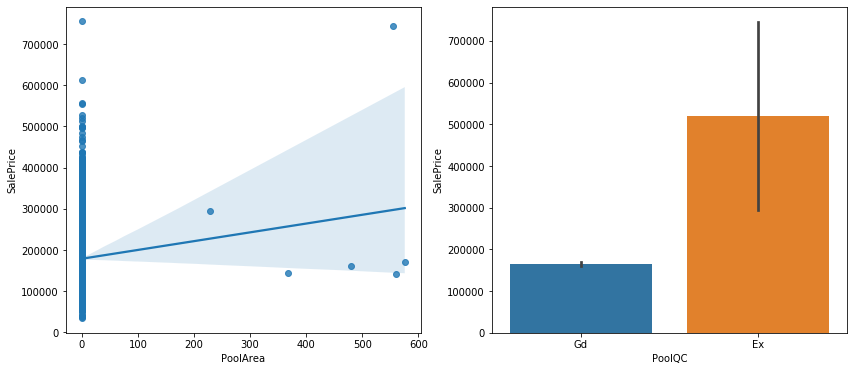

In [34]:
figure, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
figure.set_size_inches(14,6)
sns.regplot(data=data, x='PoolArea', y='SalePrice', ax=ax1) # 수영장 없는 집이 월!등!히! 많음
sns.barplot(data=data, x='PoolQC', y='SalePrice', ax=ax2)

In [35]:
all_data = all_data.drop(columns=['PoolArea','PoolQC'])

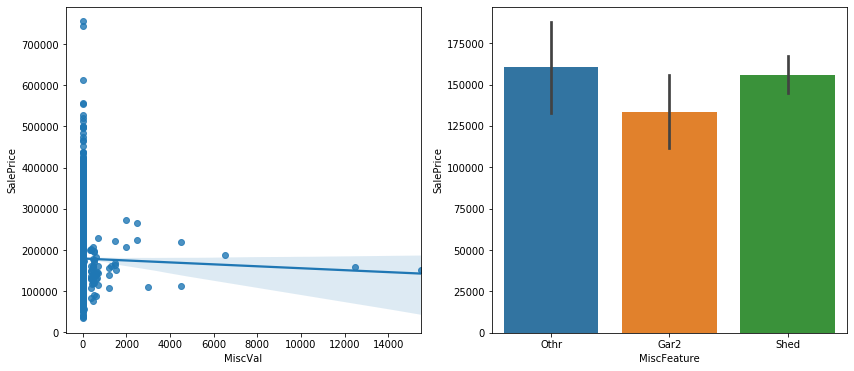

In [36]:
figure, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
figure.set_size_inches(14,6)
sns.regplot(data=data, x='MiscVal', y='SalePrice', ax=ax1) #테니스코트 없는 집도 많음(수영장만큼은 아니지만)
sns.barplot(data=data, x='MiscFeature', y='SalePrice', ax=ax2)

In [37]:
all_data=all_data.drop(columns=['MiscVal','MiscFeature'])

- 위보다는 낫지만, 결측치가 많은 경우 -> 0값만 분리해주자

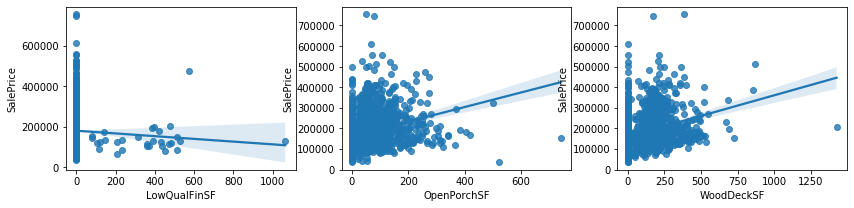

In [38]:
figure, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3)
figure.set_size_inches(14,3)
sns.regplot(data=data, x='LowQualFinSF', y='SalePrice', ax=ax1)
sns.regplot(data=data, x='OpenPorchSF', y='SalePrice', ax=ax2)
sns.regplot(data=data, x='WoodDeckSF', y='SalePrice', ax=ax3)

In [39]:
all_data['NoLowQual'] = (all_data['LowQualFinSF']==0)
all_data['NoOpenPorch'] = (all_data['OpenPorchSF']==0)
all_data['NoWoodDeck'] = (all_data['WoodDeckSF']==0)

#### 3. 전처리

1) 범주형 변수 (Categorical Feature)

In [40]:
non_numeric = all_data.select_dtypes(np.object)

def onehot(col_list):
    global all_data
    while len(col_list)!=0:
        col = col_list.pop(0)
        data_encoded = pd.get_dummies(all_data[col], prefix=col)
        all_data = pd.merge(all_data, data_encoded, on='Id')
        all_data = all_data.drop(columns=col)
    print(all_data.shape)
    
onehot(list(non_numeric))

(2917, 309)


2) 수치형 변수(Numeric Feature)

In [41]:
numeric = all_data.select_dtypes(np.number)

def log_transform(col_list):
    transformed_col=[]
    while len(col_list)!=0:
        col = col_list.pop(0)
        if all_data[col].skew() > 0.5:
            all_data[col] = np.log(all_data[col]+1)
            transformed_col.append(col)
        else:
            pass
    print(f"{len(transformed_col)} features had been tranformed")
    print(all_data.shape)

log_transform(list(numeric))

255 features had been tranformed
(2917, 309)


3) 데이터 분리

In [42]:
print(train.shape, test.shape)

(1749, 79) (1168, 79)


In [43]:
X_train = all_data[ :len(train)]
X_test = all_data[len(train): ]

print(X_train.shape, X_test.shape)

(1749, 309) (1168, 309)


#### 4. 머신러닝 모델로 학습

In [44]:
#!pip install optuna

In [45]:
#!pip install catboost

In [46]:
from sklearn.linear_model import ElasticNet, Lasso
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from xgboost import XGBRegressor
import time
import optuna
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import GridSearchCV
import xgboost as xgb
#from catboost import CatBoostRegressor


model_Lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.000327, random_state=18))

model_ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.00052, l1_ratio=0.70654, random_state=18))

model_GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05, max_depth=4,
                                         max_features='sqrt', min_samples_leaf=15, 
                                         min_samples_split=10, loss='huber', random_state=18)

param = {
    'max_depth':[2,3,4],
    'n_estimators': range(550,700,50),
    'colsample_bytree': [0,5,0,7,1],
    'colsample_bylevel': [0,5,0,7,1]
}
model = xgb.XGBRegressor()
model_GridSearch = GridSearchCV(estimator=model, param_grid=param, cv=5, 
                           scoring='neg_mean_squared_error',
                           n_jobs=-1)
#model_XGB = XGBRegressor(colsample_bylevel=0.9229733609038979, colsample_bynode=0.21481791874780318,
 #                        colsample_bytree=0.607964318297635, gamma=0.8989889254961725, 
  #                       learning_rate=0.009192310189734834, max_depth=3, n_estimators=3602,
   #                      reg_alpha=3.185674564163364e-12,reg_lambda=4.95553539265423e-13, seed=18, 
    #                     subsample=0.8381904293270576, tree_method='gpu_hist',verbosity=0)

In [47]:
#!pip uninstall  xgboost

In [48]:
#!python -m pip install xgboost

In [50]:
model_Lasso.fit(X_train, y_train)
Lasso_predictions = model_Lasso.predict(X_test)
train_Lasso = model_Lasso.predict(X_train)

model_ENet.fit(X_train, y_train)
ENet_predictions = model_ENet.predict(X_test)
train_ENet = model_ENet.predict(X_train)

#model_XGB.fit(X_train, y_train)
#XGB_predictions = model_XGB.predict(X_test)
#train_XGB = model_XGB.predict(X_train)

model_GridSearch.fit(X_train,y_train)
GridSearch_predictions = model_GridSearch.predict(X_test)
train_GridSearch = model_GridSearch.predict(X_train)


model_GBoost.fit(X_train, y_train)
GBoost_predictions = model_GBoost.predict(X_test)
train_GBoost = model_GBoost.predict(X_train)

#log_train_predictions = (train_Lasso + train_ENet + train_XGB + train_GBoost)/4
#train_score = np.sqrt(mean_squared_error(y_train, log_train_predictions))
#print(f"Scoring with train data : {train_score}")
log_train_predictions = (train_Lasso + train_ENet + train_GridSearch + train_GBoost)/4
train_score = np.sqrt(mean_squared_error(y_train, log_train_predictions))
print(f"Scoring with train data : {train_score}")

#log_predictions = (Lasso_predictions + ENet_predictions + XGB_predictions + GBoost_predictions) / 4
#predictions = np.exp(log_predictions)-1
log_predictions = (Lasso_predictions + ENet_predictions + GridSearch_predictions + GBoost_predictions) / 4
predictions = np.exp(log_predictions)-1

Scoring with train data : 0.05254963924995245


In [51]:
submission['SalePrice'] = predictions #Id.. 따로 엑셀에서 넣어줌ㅎ
submission.to_csv('submission.csv', index=False)